In [3]:
from PIL import Image
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import numpy as np
from scipy.spatial import KDTree
from itertools import combinations
import open3d as o3d

In [ ]:
org_path="/mnt/Personal/Projects/Depth_Reconstruction/Test_Folder/stereo_test/"

object_name="dustbin/"

test_input_path=org_path+"test_images/"+object_name
test_output_path=org_path+"test_outputs/"
test_3d_path=org_path+"test_3d/"

: 

: 

: 

: 

In [ ]:
class Process:

    def __init__(self, image):

        self.image = Image.open(image)

        self.image = self.image.convert('L')

    def get_info(self):

        """
        Get Image size and mode information using the Pillow library.

        Return:
            (size, mode)
        """
        im = self.image
        print(f"Image size: {im.size}")
        print(f"Image mode: {im.mode}")

        return im.size, im.mode

    def get_array(self):

        """
        Get Numpy array for the input image
        """

        self.array = np.array(self.image, dtype='int64')

        return self.array

    def resize_image(self, width, height):

        new_dim = (width, height)
        self.image = self.image.resize(new_dim)

        return 

    def slice_image(self, xi, yi, size):

        self.slice = self.array[xi:(xi + size), yi:(yi + size)]

        return self.slice

    def show_image(self):

        self.image.show()

        return

: 

: 

: 

: 

In [ ]:
def pre_process(image_path, height, width):

    """
    Pre-process an image to produce a resized, grayscale numpy array.

    :param image_path: path to input image
    :param height: resize height
    :param width: resize width

    :return: numpy array with resized dimensions
    """

    im = Process(image_path)
    im.resize_image(width, height)
    array = im.get_array()

    print(f"Pre-processing for {image_path} complete.")
    print("Information:")
    im.get_info()

    return array


: 

: 

: 

: 

In [ ]:
def calc_disparity(array_left, array_right, window_size, search_range):

    """
    Calculate a disparity matrix using two image arrays. 

    :param array_left: numpy array of the left image
    :param array_right: numpy array of the right image
    :param window_size: square window size for region matching
    :param search_range: range to apply region matching, in the (-) direction 
    
    :return: disparity matrix numpy array with (dimensions) - (window size)
    """

    start_time = time.time()

    disp_matrix = []

    for row in tqdm(range(len(array_left) - window_size)):

        # if row % 10 == 0:
        #     print(f"Disparity calculated for {row} rows.")

        disps = []

        for col1 in range(len(array_left[row]) - window_size):
            win1 = array_left[row:row + window_size, col1:col1 + window_size].flatten()

            if col1 < search_range:
                init = 0
            else:
                init = col1 - search_range

            sads = []

            for col2 in range(col1, init - 1, -1):
                win2 = array_right[row:row + window_size, col2:col2 + window_size].flatten()

                sad = np.sum(np.abs(np.subtract(win1, win2)))
                sads.append(sad)

            disparity = np.argmin(sads)
            disps.append(disparity)

        disp_matrix.append(disps)
                   
    disp_matrix = np.array(disp_matrix)

    end_time = time.time()

    print("Disparity calculations complete.")
    print(f"Time elapsed during disparity calculations: {end_time - start_time}s")

    return disp_matrix

: 

: 

: 

: 

In [ ]:
import numpy as np
from scipy import stats

def post_process(disp_matrix):
    pp_disp = np.copy(disp_matrix)
    H, W = pp_disp.shape

    for y in range(H):
        for x in range(W):

            # 1. SMOOTHING by average
            if y >= 7 and y < H - 7 and x >= 7 and x < W - 7:
                avg = np.mean(pp_disp[y - 7:y + 8, x - 7:x + 8])
                if abs(pp_disp[y, x] - avg) > 5:
                    pp_disp[y, x] = avg

            # 2. DENOISING by mode
            if pp_disp[y, x] > 25:
                if y >= 12 and y < H - 12 and x >= 12 and x < W - 12:
                    window = pp_disp[y - 12:y + 13, x - 12:x + 13].flatten()
                    mode_val = stats.mode(window, keepdims=False).mode
                    if mode_val.size > 0:
                        pp_disp[y, x] = mode_val.item()

            # 3. HARD THRESHOLD
            if pp_disp[y, x] > 30:
                pp_disp[y, x] = 25

    return pp_disp


: 

: 

: 

: 

In [ ]:

def create_txt(raw_image_path, disp_matrix, output_path):

    height = disp_matrix.shape[0]
    width = disp_matrix.shape[1]

    img = Image.open(raw_image_path)
    img = img.resize((width, height))
    arr = np.array(img)

    xyzrgb = []

    for x in range(width):
        for y in range(height):
            z = np.multiply(disp_matrix[y, x], 6)
            rgb = arr[y, x]
            xyzrgb.append([x, y, z, rgb[0], rgb[1], rgb[2]])

    df = pd.DataFrame(xyzrgb)
    df.columns = ['x', 'y', 'z', 'r', 'g', 'b']
    df.to_csv(output_path, index=False)

    print(f"Successfully created file at {output_path}.")

    return df

: 

: 

: 

: 

In [ ]:
import numpy as np
from scipy.spatial import KDTree
from tqdm import tqdm
import open3d as o3d


def pointcloud_to_ply(input_path, output_path, threshold=0.1, euclid_threshold=1.5):
    """
    Converts a structured point cloud text file to a binary_little_endian .ply mesh file using Open3D.
    Vertex positions are written as double (float64) and colors as uchar.
    Faces are built from grid and KDTree-based connections.
    """
    # Load data
    data = np.loadtxt(input_path, delimiter=',', skiprows=1)
    raw_coords = data[:, :3].astype(np.float64)  # double precision
    raw_colors = data[:, 3:].astype(np.uint8)

    for i in range(len(raw_coords)):
        raw_coords[i]=[raw_coords[i][0],raw_coords[i][1],-raw_coords[i][2]]
    
    # Deduplicate vertices
    vertex_map = {}
    vertices = []
    color_list = []
    index_lookup = []

    for i in range(len(raw_coords)):
        key = tuple(np.round(raw_coords[i], 5))
        if key not in vertex_map:
            vertex_map[key] = len(vertices)
            vertices.append(raw_coords[i])
            color_list.append(raw_colors[i])
        index_lookup.append(vertex_map[key])

    vertices = np.array(vertices, dtype=np.float64)  # double precision
    color_list = np.array(color_list, dtype=np.uint8)
    index_lookup = np.array(index_lookup)

    # Infer grid shape
    try:
        diffs = np.diff(raw_coords[:, 1])
        W = np.where(diffs < 0)[0][0] + 1
    except IndexError:
        raise ValueError("Couldn't infer width from data.")

    H = len(raw_coords) // W
    if H * W != len(raw_coords):
        raise ValueError("Point count does not match inferred grid dimensions.")

    index_map = index_lookup.reshape(H, W)

    # Face generation
    face_set = set()
    faces = []

    for y in range(H - 1):
        for x in range(W - 1):
            i1, i2, i3 = index_map[y, x], index_map[y, x + 1], index_map[y + 1, x]
            i4 = index_map[y + 1, x + 1]

            z1 = raw_coords[y * W + x][2]
            z2 = raw_coords[y * W + x + 1][2]
            z3 = raw_coords[(y + 1) * W + x][2]
            z4 = raw_coords[(y + 1) * W + x + 1][2]

            if abs(z1 - z2) < threshold and abs(z1 - z3) < threshold:
                face = tuple(sorted([i1, i2, i3]))
                if len(set(face)) == 3 and face not in face_set:
                    face_set.add(face)
                    faces.append(list(face))

            if abs(z4 - z2) < threshold and abs(z4 - z3) < threshold:
                face = tuple(sorted([i2, i4, i3]))
                if len(set(face)) == 3 and face not in face_set:
                    face_set.add(face)
                    faces.append(list(face))

    # KDTree face generation
    tree = KDTree(vertices)
    for i in tqdm(range(len(vertices)), desc="KDTree neighbors"):
        neighbors = tree.query_ball_point(vertices[i], euclid_threshold)
        for j in neighbors:
            if j > i:
                k = (i + 1) % len(vertices)
                face = tuple(sorted([i, j, k]))
                if len(set(face)) == 3 and face not in face_set:
                    face_set.add(face)
                    faces.append(list(face))

    # Construct Open3D mesh
    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(vertices)
    mesh.triangles = o3d.utility.Vector3iVector(faces)
    mesh.vertex_colors = o3d.utility.Vector3dVector(color_list.astype(np.float64) / 255.0)

    # Write mesh in binary_little_endian format
    o3d.io.write_triangle_mesh(output_path, mesh, write_ascii=False, compressed=False)
    print(f"Successfully saved mesh at: {output_path}")


: 

: 

: 

: 

In [ ]:
def render_object():

    image_path_left = test_input_path+"im0.png"
    image_path_right = test_input_path+"im1.png"

    # org - 1924, 2864
    org = [1924,2864]
    scale = 0.5
    
    height = int(org[0]*scale)
    width = int(org[1]*scale)

    window_size = 20
    search_range = 200
    
    post_process_count = 5

    output_image_path = test_output_path+f"{height}.png"
    output_txt_path = test_3d_path+f"point_cloud_{height}.txt"
    output_3d_path = test_3d_path+f"ply_{height}.ply"

    array_left = pre_process(image_path=image_path_left,
                             height=height,
                             width=width)
    array_right = pre_process(image_path=image_path_right,
                              height=height,
                              width=width)

    disp_matrix = calc_disparity(array_left=array_left,
                                 array_right=array_right,
                                 window_size=window_size,
                                 search_range=search_range)
    
    

    proc_disp_matrix = post_process(disp_matrix=disp_matrix)
    
    for _ in tqdm(range(post_process_count)):
        proc_disp_matrix = post_process(disp_matrix=proc_disp_matrix)
        
    print(f"Post-processing for disparity matrix of shape {disp_matrix.shape} complete.")

    df = create_txt(raw_image_path=image_path_left,
                    disp_matrix=proc_disp_matrix,
                    output_path=output_txt_path)
    
    pointcloud_to_ply(output_txt_path,output_3d_path,threshold=0.5, euclid_threshold=0.5)

    plt.imshow(proc_disp_matrix)
    plt.savefig(output_image_path)

: 

: 

: 

: 

Pre-processing for /mnt/Personal/Projects/Depth_Reconstruction/Test_Folder/stereo_test/test_images/dustbin/im0.png complete.
Information:
Image size: (429, 288)
Image mode: L
Pre-processing for /mnt/Personal/Projects/Depth_Reconstruction/Test_Folder/stereo_test/test_images/dustbin/im1.png complete.
Information:
Image size: (429, 288)
Image mode: L


100%|██████████| 284/284 [00:19<00:00, 14.37it/s]


Disparity calculations complete.
Time elapsed during disparity calculations: 19.771066904067993s


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Post-processing for disparity matrix of shape (284, 425) complete.
Successfully created file at /mnt/Personal/Projects/Depth_Reconstruction/Test_Folder/stereo_test/test_3d/point_cloud_288.txt.


KDTree neighbors: 100%|██████████| 120700/120700 [00:00<00:00, 278318.83it/s]


Successfully saved mesh at: /mnt/Personal/Projects/Depth_Reconstruction/Test_Folder/stereo_test/test_3d/ply_288.ply


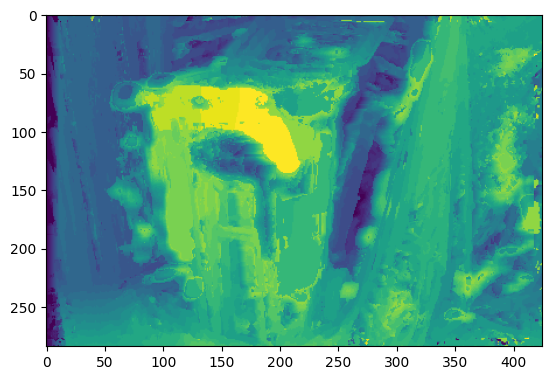

: 

: 

: 

: 

In [ ]:
render_object()